# Model Implimentation

In [1]:
import numpy as np
from scipy.integrate import odeint

In [2]:
# ------------------------------------------------------------------------
# Assumptions from the Paper:
# ------------------------------------------------------------------------
# 1. Uniform gas flow in a single direction.
# 2. Convective heat transfer between gas and beans.
# 3. Average bean size and properties.
# 4. Rotating drum with bean-metal and bean-gas contact.
# 5. Negligible external heat sources (Qe).
# 6. Semi-empirical model for moisture loss and exothermic reactions.
# 7. First-order sensor dynamics for bean temperature measurement.

# ------------------------------------------------------------------------
# Additional Assumptions:
# ------------------------------------------------------------------------
# # 3. Specific values for geometrical and bean parameters (hypothetical).

# ------------------------------------------------------------------------
# Model Parameters (Hypothetical):
# ------------------------------------------------------------------------

In [3]:
# Fixed Parameters:
A = 116200 * 1000 # J/kg
cm = 0.418 * 1000  # J/(kg °C)
cw = 5 * 1000  # J/(kg °C)
Db = 7.65e-3 # m
Ha_R = 5500  # K (this is Ha/R)
Het = 232 * 1000  # J/kg
k1 = 4.32e-9
k2 = 9889
Kt = 0.01   # 1/s
mb = 1.5e-4  # kg
λ = 2790 * 1000    # J/kg

In [4]:
# Scalable Parameters (Hypothetical):
Mb = 120     # kg #Also 320 kg
Dch = 1.24   # m #Also 1.90
Hflap = 0.3  # m
Lch = 1.335  # m #Also 2.04
Mm = 2000    # kg #also 7000
Sflap = 0.1  # m
Pbm = 0.5793  # Hypothetical value for bean-metal contact area (this is a percentatge and it relies on the amount of beans and the geometry of the roaster)

In [5]:
#heat transfer coefficients
hgm = 105 #0.01  # W/(m^2*K) Hypothetical value (although these could change as a function of something else)
hbm = 30 #0.0254  # W/(m^2*K) Hypothetical value (although these could change as a function of something else)

In [6]:
# ------------------------------------------------------------------------
# Model Equations:
# ------------------------------------------------------------------------

In [7]:
def coffee_roasting_model(x, t):
    # Inputs (hypothetical):
    Tgi = input_Tgi(t)   # Inlet gas temperature

    # Gas flow rate dynamics:
    Gg = input_Gg(t) # input gas rates
    dGgdt = input_dGgdt(t)

    # State variables:
    Tb, Tm, X, He, Ta = x

    # Calculate specific heat capacities:
    cs = 1.099 + 0.007 * Tb # partial heat capacity of solid beans
    cb = (cs + cw * X) / (1 + X) # Specfic heat of coffee beans

    # Gas-to-beans heat transfer area:
    Ab = calc_Ab(Mb, mb, Db) # (Mb / mb) * np.pi * Db**2
    Agb = calc_Agb(Ab, Pbm) # Ab * (1 - Pbm)

    # Other heat transfer areas:
    Agm = calc_Agm(Dch, Lch, Hflap, Sflap) #np.pi * Dch * (Lch + (Hflap * Lch) / Sflap + Dch / 2)
    Abm = Ab * Pbm

    # Heat transfer coefficients:
    he = calc_he(X) #0.49 - 0.443 * np.exp(-0.206 * X)

    # Calculate heat transfer rates:
    F = calc_F(hgm, Agm, he, Agb) #hgm * Agm / (he * Agb)
    Qgb = Gg * cg((Tgi+Tgo(x,Gg,Tgi))/2) * (Tgi - Tgo(x, Gg, Tgi)) # gas to bean heat transfer rate
    Qgm = F * (he * Agb * (Tb - Tm) + Qgb) / (1 + F) # gas to metal heat transfer rate
    Qbm = hbm * Abm * (Tm - Tb) # metal to beans heat transfer rate

    # Calculate moisture loss and exothermic heat:
    dXdt = -k1 / Db**2 * np.exp(-k2 / (Tb + 273.15))
    Qr = A * (Het - He) / Het * np.exp(-Ha_R / (Tb + 273.15))

    # Bean temperature dynamics:
    Mbd = Mb / (1 + X)
    dTbdt = (Qgb - Qgm + Qbm + Mbd * (Qr + λ * dXdt)) / (Mbd * (1 + X) * cb)

    # Metal temperature dynamics:
    dTmdt = (Qgm - Qbm) / (Mm * cm)

    # Sensor dynamics for measured bean temperature:
    dTadt = Kt * (Tb - Ta)

    # Energy conservation check
    heat_out_of_gas = Qgb + Qgm
    heat_change_in_gas = Gg * cg(Tgi) * (Tgi - Tgo(x, Gg, Tgi))

    #print(f'heat out: {heat_out_of_gas} | gas_change: {heat_change_in_gas}')
    # Debugging
    #print(f' ____start______\ Gg {Gg}\n Tgi {Tgi}\n Tgo {Tgo(x,Gg,Tgi)} \n Qr {Qr}\n Qgb {Qgb}\n Qgm {Qgm}\n Qbm {Qbm}\n He {He}\n Agb {Agb}\n Agm {Agm}\n Abm {Abm}\n cs {cs}\n cb {cb}\n cg {cg(Tgi)}\n cm {cm}\n he {he}\n hgm {hgm}\n hbm {hbm}\n ')
    #input()
    return np.array([dTbdt, dTmdt, dXdt, Qr, dTadt])


In [8]:
def calc_Ab(Mb, mb, Db):
  return (Mb / mb) * np.pi * Db**2

In [9]:
def calc_Agb(Ab, Pbm):
  return Ab * (1 - Pbm)

In [10]:
def calc_Agm(Dch, Lch, Hflap, Sflap):
  return np.pi * Dch * (Lch + (Hflap * Lch) / Sflap + Dch / 2)

In [11]:
def calc_F(hgm, Agm, he, Agb):
  Ab = calc_Ab(Mb, mb, Db)
  Agb = calc_Agb(Ab, Pbm)
  return hgm * Agm / (he * Agb)

In [12]:
def calc_he(X):
  return 0.49 - 0.443 * np.exp(-0.206 * X)

In [13]:
# Function for gas specific heat capacity (from paper):
def cg(T):
    alpha = [1.0839e3, -7.2075e-1, 2.1034e-3, -2.3267e-6, 1.3621e-9, -4.1550e-13, 5.3091e-17]
    return sum([alpha[i] * (T + 273.15)**i for i in range(7)])

In [14]:
# Function for outlet gas temperature (from paper):
def Tgo(x, Gg, Tgi):
    Tb, Tm, X, He, Ta = x

    Ab = calc_Ab(Mb, mb, Db)
    Agb = calc_Agb(Ab, Pbm)
    he = calc_he(X)
    Agm = calc_Agm(Dch, Lch, Hflap, Sflap)
    F = calc_F(hgm, Agm, he, Agb)
    return Tgi - ((Tb + F * Tm) / (1 + F)) * (1 - np.exp(-he * Agb * (1 + F) / (Gg * cg(Tgi))))

In [15]:
# ------------------------------------------------------------------------
# Example Usage (Hypothetical Data):
# ------------------------------------------------------------------------

In [16]:
# Define inputs:

In [17]:
def input_Gg(t):
  # if t<400:
  #   return 5
  # else:
  #   return 0.1
  return 0.4 + 0.1*np.sin(0.01 * t) +  0.1*np.sin(0.08 * t) # kg/s

In [18]:
def input_Tgi(t):
  # if t<100:
  #   return 100
  # elif t>=100:
  #   return 300
  # else:
  #   return 200
  return 250 + 100 * np.cos(0.02 * t) + 100*np.sin(0.08*t) # deg. C

In [19]:
def input_dGgdt(t):
  return 0.1*0.01*np.cos(0.01*t) + 0.1*0.08*np.cos(0.08*t)

In [20]:
# Time points
t = np.linspace(0, 600, 601)  # 10 minutes with 1-second resolution

# Initial conditions:
Tb0 = 30     # Initial bean temperature
Tm0 = 121    # Initial metal temperature
X0 = 0.1     # Initial moisture content
He0 = 0      # Initial exothermic heat
Ta0 = 121     # Initial measured bean temperature

x0 = [Tb0, Tm0, X0, He0, Ta0]  # Initial values for state variables

# Solve the system of equations:
# sole is [Tb, Tm, X0, He, Ta]
sol = odeint(coffee_roasting_model, x0, t)

# Extract bean temperature:
bean_temp = sol[:, 0] # Actual bean temperature (Tb)
measured_bean_temp = sol[:,4] # Measured bean temperature (Ta)

# ... further analysis and visualization

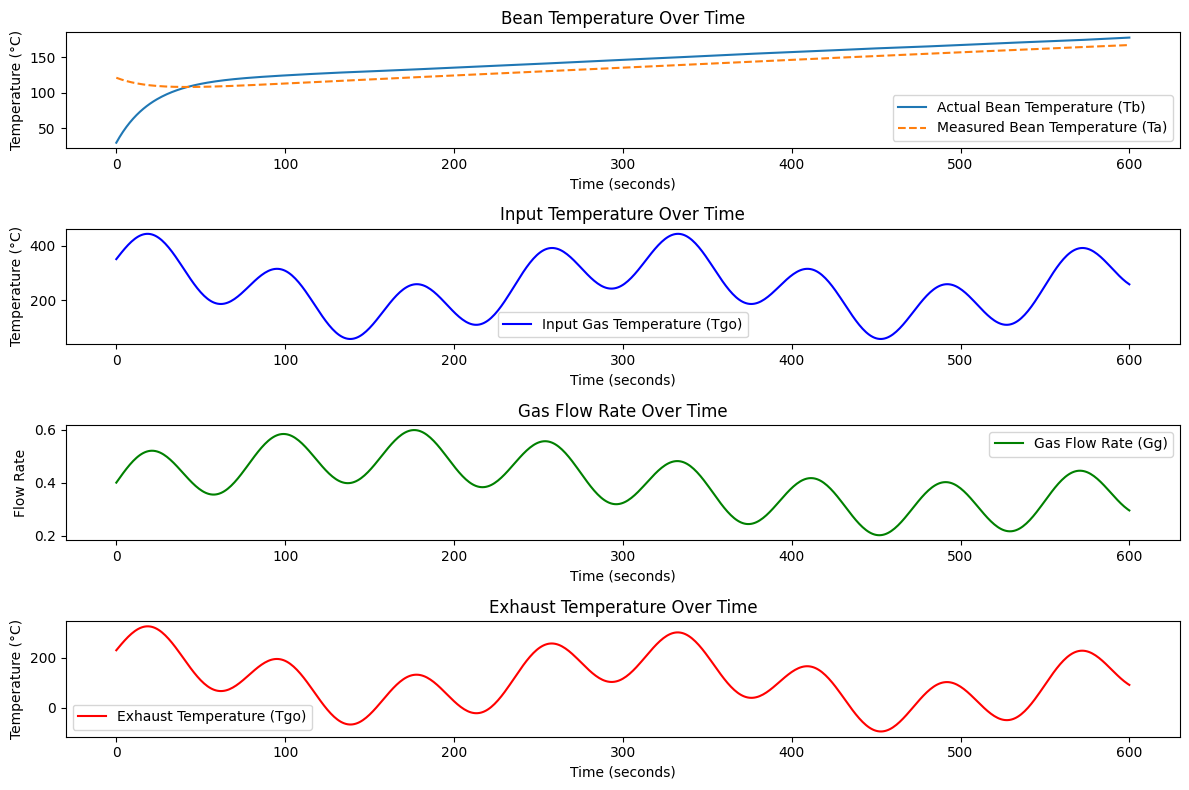

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have already computed 'sol' and have the 't' array
# sol -> [Tb, Tm, X, He, Ta]
bean_temp = sol[:, 0]  # Actual bean temperature (Tb)
measured_bean_temp = sol[:, 4]  # Measured bean temperature (Ta)

# input temperature
vectorized_input_Tgi = np.vectorize(input_Tgi)
input_gas_temp = vectorized_input_Tgi(t)
vectorized_input_Gg = np.vectorize(input_Gg)
input_gas_flow = vectorized_input_Gg(t)

# # input temp and gas rate
# # Use below when the input temp and gas are constants
# input_gas_temp = input_Tgi(t) * np.ones_like(t)
# input_gas_flow = input_Gg(t) * np.ones_like(t) # Gas flow rate (Gg) (treated as an input)

# if you are using conditions to do a stepfunction


# Compute the exhaust temperature Tgo (You'll need to define the function or computation)
# Example function to compute Tgo; replace this with your actual function
def compute_tgo(sol, t):
    Tgo_values = np.zeros_like(t)  # Placeholder array
    for i, state in enumerate(sol):
        # Assuming a function `calculate_Tgo` that computes Tgo given the state at time t[i]
        Tgo_values[i] = Tgo(state, input_Gg(t[i]), input_Tgi(t[i]))
    return Tgo_values

Tgo_values = compute_tgo(sol, t)

# Plotting
plt.figure(figsize=(12, 8))

# Plot Bean Temperature
plt.subplot(4, 1, 1)  # 3 rows, 1 column, 1st subplot
plt.plot(t, bean_temp, label='Actual Bean Temperature (Tb)')
plt.plot(t, measured_bean_temp, label='Measured Bean Temperature (Ta)', linestyle='--')
plt.title('Bean Temperature Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot Exhaust Temperature
plt.subplot(4, 1, 2)  # 3 rows, 1 column, 3rd subplot
plt.plot(t, input_gas_temp, color='blue', label='Input Gas Temperature (Tgo)')
plt.title('Input Temperature Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot Gas Flow Rate
plt.subplot(4, 1, 3)  # 3 rows, 1 column, 2nd subplot
plt.plot(t, input_gas_flow, color='green', label='Gas Flow Rate (Gg)')
plt.title('Gas Flow Rate Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Flow Rate')
plt.legend()

# Plot Exhaust Temperature
plt.subplot(4, 1, 4)  # 3 rows, 1 column, 3rd subplot
plt.plot(t, Tgo_values, color='red', label='Exhaust Temperature (Tgo)')
plt.title('Exhaust Temperature Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

# Coffee Roaster Data Implimentation

In [ ]:
cd